# Claira Project: Mortgage Contracts

## Import Packages

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import string
import numpy as np
import gzip
import seaborn as sns
np.random.seed(99)
RANDOM_STATE = 99
import datetime
pd.set_option('display.max_rows', 151)


# Import vectorizing and modeling tools in preparation for modeling steps
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.feature_extraction import text, stop_words
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier
import time

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

import spacy
import en_core_web_lg
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
nlp = spacy.load('en_core_web_sm', disable = ['ner', 'parser'])

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_curve, auc

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [55]:
# printing functions
def explore_data_cleaning(raw_df):
    trigger_order = raw_df['Trigger'].value_counts().sort_values(ascending = False).index

    fig = plt.gcf()
    fig.set_size_inches(8, 8)
    ax = sns.countplot(y=raw_df['Trigger'], data=raw_df, orient = 'h', order = trigger_order)
    ax.set_title('Number of Trigger Types');

    for p in ax.patches:
        ax.annotate(int(p.get_width()),((p.get_x() + p.get_width()), p.get_y()), xytext=(17, -15),fontsize=9,textcoords='offset points', horizontalalignment='right')

    #https://stackoverflow.com/questions/50190409/how-to-annotate-horizontal-seaborn-countplots
    return

In [56]:
# function to get data 
def get_data():
    # Import the CSV file
    raw_df = pd.read_csv('../data/sasb_cash_trap_triggers_06_04_20.csv')
    return raw_df

# function to clean data
def clean_data(raw_df, print_fns=False):
    # project out extra columns
    raw_df = raw_df[['Document', 'Sentence', 'Trigger', 'Multiclass']]
    
    # Convert each category to Title format (to remove discrepancies based on capitalization)
    raw_df['Trigger'] = raw_df['Trigger'].str.title()

    # Some data fixes
    raw_df['Trigger'] = raw_df['Trigger'].str.replace('Falll', 'Fall')
    raw_df.loc[raw_df['Trigger'] == 'Aggregate Debt Yield', 'Trigger'] = 'Aggregate Debt Yield Fall'

    # Some dollar sign symbols are causing problems - will remove them here
    raw_df['Sentence'] = raw_df['Sentence'].replace({'\$':''}, regex = True)

    # Drop Multiclass column since it isn't needed
    raw_df = raw_df.drop('Multiclass', axis = 1)
    
    # Count the number of distinct documents
    num_docs = raw_df['Document'].nunique()
    print(f'{num_docs} unique documents have been included in the data set')
    
    # Summarize the trigger counts for the existing Document set
    max_triggers = raw_df['Document'].value_counts().max()
    min_triggers = raw_df['Document'].value_counts().min()
    print(f'The {num_docs} Documents have tag counts that range from {min_triggers} to {max_triggers}.')

    # run the extra code that analyzes the data
    if print_fns:
        explore_data_cleaning(raw_df)
        
    return raw_df


In [57]:
# function to reshape the dataframe such that the triggers are 0/1 columns. Remove duplicates
def reshape_trigger_representation(dataframe):
    # select trigger types
    trigger_types = list(dataframe['Trigger'].unique())
    trigger_types = [x for x in trigger_types if str(x) != 'nan']

    # create new dataframe with unique document-sentence pairs (no duplicates)
    reshaped = dataframe.drop('Trigger', axis = 1).drop_duplicates().reset_index().drop('index', axis = 1)

    # select rows by trigger, reassign as 1 or 0 (for True or False)
    for tt in trigger_types:
        # select part that is trigger_type
        temp = dataframe.loc[dataframe['Trigger'] == tt].copy()

        # create a new column of true with trigger name
        temp[tt.lower().replace(' ', '_')] = np.int64(1)
        temp.drop('Trigger', axis=1, inplace=True)
        temp[tt.lower().replace(' ', '_')] = temp[tt.lower().replace(' ', '_')].astype('Int64')

        # left join this adjusted column to the unique data
        reshaped = reshaped.merge(temp, how='left', left_on=['Document', 'Sentence'], right_on=['Document', 'Sentence'])

    # replace nulls with False
    reshaped = reshaped.fillna(0)    
    
    return reshaped

In [58]:
def tokenize(text):
    doc = nlp(text)
    tokens = [token.text for token in doc]
    return ' '.join(tokens)

In [59]:
def lemmatize(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    return ' '.join(lemmas)

In [ ]:
# NLP processing the sentence columns to prep for models
def tokenize_sentences(dataframe):
    print('Tokenizing...')
    dataframe['SentenceTokens'] = dataframe['Sentence'].apply(tokenize)
    dataframe['SentenceLemmas'] = dataframe['Sentence'].apply(lemmatize)
    print(f"{len(dataframe['Sentence'])} sentences have been tokenized and lemmatized.")
    return dataframe

In [61]:
# stop words - get them
def get_stopwords():
    # might need space
    short_stopwords = ['the', 'to', 'of', 'be', 'and', 'in', 'a']
    short_stopwords2 = ['the', 'and', 'a', 'to', 'it', 'be', 'for', 'with', 'that']
    stopwords = list(STOP_WORDS)

    return short_stopwords, short_stopwords2, stopwords

In [62]:
# function to split data
def get_split_data(df, target_info):
    # extract target name
    target = target_info['target']
    x_col  = target_info['x_col']
    
    # create X, Y
    X = df[x_col]
    y = df[target]
    indices = df.index

    y = y.astype('int')

    # run test, train split
    X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size = 0.3, stratify = y, random_state = RANDOM_STATE)

    # print information
    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)
    print(indices_train.shape, indices_test.shape)
    
    # create output dictionary
    split_data = {}
    split_data['X_train'] = X_train
    split_data['X_test'] = X_test
    split_data['y_train'] = y_train
    split_data['y_test'] = y_test
    split_data['indices_train'] = indices_train
    split_data['indices_test'] = indices_test
    
    return split_data

In [74]:
# run the model with the chosen model and metric
def run_model(split_data, target_info):

    # get stopwords
    short_stopwords, short_stopwords2, stopwords = get_stopwords()
    
    # set pipeline according to the selected model:
    if target_info['model'] == 'lr':
        # Define CVEC + Logistic Regression Pipeline
        pipe = Pipeline([('cvec', CountVectorizer()), ('lr', LogisticRegression(solver = 'liblinear', random_state = RANDOM_STATE))])
        params = {
            'cvec__ngram_range': [(1,2), (1,3), (1,4), (1,5), (1,6), (1,7), (1,8)],
            'cvec__stop_words': [None, short_stopwords, short_stopwords2, stopwords],  
            'cvec__max_features': [100, 200, 400, 600, 1000],
            'cvec__min_df': [2],
            'cvec__max_df': [.99],
            }

    elif target_info['model'] == 'rf':
        # Define CVEC + Logistic Regression Pipeline
        pipe = Pipeline([('cvec', CountVectorizer()), ('rf', RandomForestClassifier(random_state = RANDOM_STATE, n_jobs = 2))])
        params = {
            'cvec__ngram_range': [(1,2), (1,3), (1,4), (1,5)],
            'cvec__stop_words': [None, short_stopwords, short_stopwords2],  
            'cvec__max_features': [100, 200, 400, 800],
            'cvec__min_df': [2],
            'cvec__max_df': [.99],
            'rf__max_depth': [4,5, 6],
            'rf__min_samples_split': [2,3],
            'rf__min_samples_leaf': [10, 12]
            }

    
    else:
        print('did not specify model throw errrorrrrorrror')

    # define pipeline
    gs_model = GridSearchCV(pipe, param_grid = params, cv = 3, scoring = target_info['metric'])

    # Start the timer.
    t0 = time.time()

    # extract x/y_train
    X_train = split_data['X_train']
    y_train = split_data['y_train']
    
    # run pipeline
    model_result = gs_model.fit(X_train, y_train)

    print(f'Seconds elapsed for fitting: {(time.time() - t0):.3f}') # How many seconds elapsed.
        
    return model_result

In [75]:
# Control of the main project

# define dictionary of targets contains: tag, model, metric, input, order
target_dict = {}
target_dict['loan_default'] = {'target': 'loan_default', 'model': 'lr', 'metric':'f1', 'x_col':'Sentence'}
#target_dict['unspecified'] = {'target': 'unspecified', 'model': 'lr', 'metric':'f1', 'x_col':'Sentence'}

# set output_dict - will contain target + output of calculations
output_dict = {}

# get data
raw_df = get_data()
raw_df = clean_data(raw_df)

# Reshape our original dataframe and tokenize to prepare sentences for models
df = reshape_trigger_representation(raw_df)
df = tokenize_sentences(df)

# run for each model definition
for k,v in target_dict.items():
    
    # get split data
    split_data = get_split_data(df, v)
    
    # run model
    model_result = run_model(split_data, v)
    
    # make the output dictionary
    output_dict[k] = v
    output_dict[k]['split_data'] = split_data
    output_dict[k]['model_result'] = model_result
    
    

    
    
    







22 unique documents have been included in the data set
The 22 Documents have tag counts that range from 25 to 176.
tokenizing...
1866 sentences have been tokenized and lemmatized.
(1306,) (1306,)
(560,) (560,)
(1306,) (560,)
Seconds elapsed for fitting: 212.047


In [81]:
output_dict['loan_default']['model_result']

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prep

## Import Data

In [2]:
# Import the CSV file
# raw_df = pd.read_csv('../data/sasb_cash_trap_triggers.csv')

In [3]:
# Import the CSV file
raw_df = pd.read_csv('../data/sasb_cash_trap_triggers_06_04_20.csv')

In [4]:
# Review the first few rows of the data set
raw_df.head()

,Document,Sentence,Trigger,Multiclass
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",Loan Default,0
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Aggregate DSCR Fall,1
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Loan Default,1
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,Loan Default,0
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,Loan Default,0


In [5]:
# Check size of the data set
raw_df.shape

(2008, 4)

In [6]:
raw_df = raw_df[['Document', 'Sentence', 'Trigger', 'Multiclass']]

In [7]:
# Check for null values
raw_df.isnull().sum()

Document      0
Sentence      0
Trigger       0
Multiclass    0
dtype: int64

In [8]:
raw_df.dropna()
raw_df.shape

(2008, 4)

In [9]:
raw_df.head()

,Document,Sentence,Trigger,Multiclass
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",Loan Default,0
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Aggregate DSCR Fall,1
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Loan Default,1
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,Loan Default,0
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,Loan Default,0


## Data Cleaning

In [10]:
# Review number of Trigger types
raw_df['Trigger'].value_counts()

nontrigger                   1056
Unspecified                   286
Loan Default                  252
Debt Yield Fall                95
Loan default                   75
Mezzanine Default              39
Tenant Failure                 35
Debt yield fall                34
Bankruptcy                     29
DSCR Fall                      18
Operator Termination           17
Renovations                    16
Sponsor Termination            14
Aggregate Debt Yield Fall      11
Mezzanine Outstanding          10
Mezzanine default               8
Aggregate debt yield fall       6
Debt Yield Falll                4
Aggregate DSCR Fall             2
Aggregate debt yield            1
Name: Trigger, dtype: int64

In [11]:
# Convert each category to Title format (to remove discrepancies based on capitalization)
raw_df['Trigger'] = raw_df['Trigger'].str.title()

In [12]:
# Some data fixes
raw_df['Trigger'] = raw_df['Trigger'].str.replace('Falll', 'Fall')
raw_df.loc[raw_df['Trigger'] == 'Aggregate Debt Yield', 'Trigger'] = 'Aggregate Debt Yield Fall'

In [13]:
# Some dollar sign symbols are causing problems - will remove them here
raw_df['Sentence'] = raw_df['Sentence'].replace({'\$':''}, regex = True)

In [14]:
# Review clean Trigger Types
raw_df['Trigger'].value_counts()

Nontrigger                   1056
Loan Default                  327
Unspecified                   286
Debt Yield Fall               133
Mezzanine Default              47
Tenant Failure                 35
Bankruptcy                     29
Aggregate Debt Yield Fall      18
Dscr Fall                      18
Operator Termination           17
Renovations                    16
Sponsor Termination            14
Mezzanine Outstanding          10
Aggregate Dscr Fall             2
Name: Trigger, dtype: int64

In [15]:
# Drop Multiclass column since it isn't needed
raw_df = raw_df.drop('Multiclass', axis = 1)
raw_df.head()

,Document,Sentence,Trigger
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",Loan Default
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Aggregate Dscr Fall
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Loan Default
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,Loan Default
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,Loan Default


In [16]:
raw_df.shape

(2008, 3)

In [17]:
# Count the number of distinct documents
num_docs = raw_df['Document'].nunique()
print(f'{num_docs} unique documents have been included in the data set')

22 unique documents have been included in the data set


In [18]:
# Review the distinct documents and the number of Trigger events identified for each
raw_df['Document'].value_counts()

20181231_02IEP9_Prospectus_SD000000002568455603.pdf    176
20190220_02IPLU_Prospectus_SD000000002587491183.pdf    138
20190220_02IUQ7_Prospectus_SD000000002587520085.pdf    135
20160510_02B0XU_Prospectus_SD000000002312723382.pdf    125
20190108_02IFF1_Prospectus_SD000000002570458466.pdf    118
20190131_02IFCW_Prospectus_SD000000002578232050.pdf    114
20190131_02IFDN_Prospectus_SD000000002578234912.pdf    112
20190131_02IFE7_Prospectus_SD000000002578234792.pdf    111
20190208_02IM7M_Prospectus_SD000000002581684036.pdf    109
20190205_02IJ77_Prospectus_SD000000002579874729.pdf     99
20170616_02DNAM_Prospectus_SD000000002355931744.pdf     84
20180125_02FE6L_Prospectus_SD000000002394837596.pdf     82
20170814_02E227_Prospectus_SD000000002367167139.pdf     82
20170727_02DTVX_Prospectus_SD000000002362015714.pdf     75
20170525_02DG4Z_Prospectus_SD000000002352418696.pdf     75
20170525_02DFUI_Prospectus_SD000000002352389122.pdf     68
20120828_01Y0R8_Prospectus_CM000000002058750876.pdf     

In [19]:
# Summarize the trigger counts for the existing Document set
max_triggers = raw_df['Document'].value_counts().max()
min_triggers = raw_df['Document'].value_counts().min()
print(f'The {num_docs} Documents have tag counts that range from {min_triggers} to {max_triggers}.')

The 22 Documents have tag counts that range from 25 to 176.


In [20]:
raw_df.head()

,Document,Sentence,Trigger
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",Loan Default
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Aggregate Dscr Fall
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Loan Default
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,Loan Default
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,Loan Default


In [21]:
# Review new number of Trigger types
raw_df['Trigger'].value_counts()

Nontrigger                   1056
Loan Default                  327
Unspecified                   286
Debt Yield Fall               133
Mezzanine Default              47
Tenant Failure                 35
Bankruptcy                     29
Aggregate Debt Yield Fall      18
Dscr Fall                      18
Operator Termination           17
Renovations                    16
Sponsor Termination            14
Mezzanine Outstanding          10
Aggregate Dscr Fall             2
Name: Trigger, dtype: int64

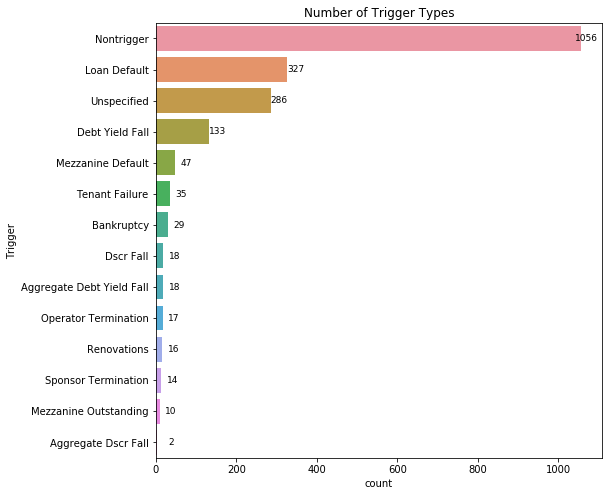

In [22]:
trigger_order = raw_df['Trigger'].value_counts().sort_values(ascending = False).index

fig = plt.gcf()
fig.set_size_inches(8, 8)
ax = sns.countplot(y=raw_df['Trigger'], data=raw_df, orient = 'h', order = trigger_order)
ax.set_title('Number of Trigger Types');

for p in ax.patches:
    ax.annotate(int(p.get_width()),((p.get_x() + p.get_width()), p.get_y()), xytext=(17, -15),fontsize=9,textcoords='offset points', horizontalalignment='right')
    
#https://stackoverflow.com/questions/50190409/how-to-annotate-horizontal-seaborn-countplots

In [23]:
# Review new distinct documents and the number of Trigger events identified for each
raw_df['Document'].value_counts()

20181231_02IEP9_Prospectus_SD000000002568455603.pdf    176
20190220_02IPLU_Prospectus_SD000000002587491183.pdf    138
20190220_02IUQ7_Prospectus_SD000000002587520085.pdf    135
20160510_02B0XU_Prospectus_SD000000002312723382.pdf    125
20190108_02IFF1_Prospectus_SD000000002570458466.pdf    118
20190131_02IFCW_Prospectus_SD000000002578232050.pdf    114
20190131_02IFDN_Prospectus_SD000000002578234912.pdf    112
20190131_02IFE7_Prospectus_SD000000002578234792.pdf    111
20190208_02IM7M_Prospectus_SD000000002581684036.pdf    109
20190205_02IJ77_Prospectus_SD000000002579874729.pdf     99
20170616_02DNAM_Prospectus_SD000000002355931744.pdf     84
20180125_02FE6L_Prospectus_SD000000002394837596.pdf     82
20170814_02E227_Prospectus_SD000000002367167139.pdf     82
20170727_02DTVX_Prospectus_SD000000002362015714.pdf     75
20170525_02DG4Z_Prospectus_SD000000002352418696.pdf     75
20170525_02DFUI_Prospectus_SD000000002352389122.pdf     68
20120828_01Y0R8_Prospectus_CM000000002058750876.pdf     

In [24]:
raw_df.dtypes

Document    object
Sentence    object
Trigger     object
dtype: object

## Reshape the Data

In this section, we'll reshape the data, such that each sentence is represented once, with separate categorization columns for each Trigger type

In [26]:
# Reshape our original dataframe
df = reshape_trigger_representation(raw_df)

In [27]:
df.head(5)

,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,Available funds in each Cash Management Accoun...,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [28]:
# Export reshaped to CSV file
#df.to_csv('../data/reshaped_06_04_20.csv')

In [39]:
# Create list of tag types (for later modeling)
trigger_list = list(df.columns)
trigger_list

['Document',
 'Sentence',
 'loan_default',
 'aggregate_dscr_fall',
 'dscr_fall',
 'unspecified',
 'debt_yield_fall',
 'aggregate_debt_yield_fall',
 'mezzanine_default',
 'tenant_failure',
 'mezzanine_outstanding',
 'operator_termination',
 'bankruptcy',
 'sponsor_termination',
 'renovations',
 'nontrigger']

In [43]:
if 'Document' in trigger_list: trigger_list.remove('Document')
if 'Sentence' in trigger_list: trigger_list.remove('Sentence')
trigger_list

['loan_default',
 'aggregate_dscr_fall',
 'dscr_fall',
 'unspecified',
 'debt_yield_fall',
 'aggregate_debt_yield_fall',
 'mezzanine_default',
 'tenant_failure',
 'mezzanine_outstanding',
 'operator_termination',
 'bankruptcy',
 'sponsor_termination',
 'renovations',
 'nontrigger']

In [ ]:
# Create a dataframe showing the document tagging details (removing sentence details)
doc_view = df.groupby('Document').sum()


In [ ]:
doc_view.T

In [ ]:
number_tag_types = doc_view.astype(bool).sum(axis=1)
number_tag_types

In [ ]:
print(f'The number of tags per document ranges from {number_tag_types.min()} to {number_tag_types.max()}.')

In [ ]:
# Create a sum column
doc_view['sum'] = doc_view.sum(axis = 1)
doc_view

In [ ]:
# Export reshaped to CSV file
#doc_view.to_csv('../data/doc_view_06_04_20.csv')

In [ ]:
# Isolate documents that don't have any Trigger tags (only nontriggers)
no_trigger_tags = list(doc_view.loc[doc_view['sum'] == doc_view['nontrigger']].index)
no_trigger_tags # Save document names to a list

In [ ]:
# we will remove any documents that have 0 Cash Trap Trigger clauses within the data set

to_remove = df[df['Document'].isin(no_trigger_tags)]
df = df.drop(to_remove.index)

In [ ]:
doc_view.T

## Natural Language Processing / Feature Engineering

In [ ]:
# Create a column with length of Sentence
df['sentence_char_count'] = df['Sentence'].str.len()

In [ ]:
df.head()

In [ ]:
nlp = spacy.load('en_core_web_sm', disable = ['ner', 'parser'])

In [ ]:
# Review a tokenized sample Sentence
[token.text for token in nlp(df['Sentence'][2])]

In [ ]:
# Review a lemmatized sample Sentence
[token.lemma_ for token in nlp(df['Sentence'][2])]

In [ ]:
def tokenize(text):
    doc = nlp(text)
    tokens = [token.text for token in doc]
    return ' '.join(tokens)

df['SentenceTokens'] = df['Sentence'].apply(tokenize)

In [ ]:
def lemmatize(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    return ' '.join(lemmas)

df['SentenceLemmas'] = df['Sentence'].apply(lemmatize)

In [ ]:
df.head()

In [ ]:
# Put all sentences into a list of review tokens
all_sentence_tokens = ' '.join(df['SentenceTokens'])
all_sentence_tokens[:75]

In [ ]:
# Put all sentences into a list of review lemmas
all_sentence_lemmas = ' '.join(df['SentenceLemmas'])
all_sentence_lemmas[:75]

In [ ]:
sentence_token_list = [token for token in all_sentence_tokens.split(' ')]
sentence_lemma_list = [lemma for lemma in all_sentence_lemmas.split(' ')]

In [ ]:
token_df = pd.Series(sentence_token_list)
lemma_df = pd.Series(sentence_lemma_list)

In [ ]:
# Plotting the raw token count
token_series = token_df.value_counts().head(15).sort_values(ascending = True)
ax = token_series.plot.barh(figsize = (6,6))
ax.set_xlabel('count')
ax.set_ylabel('token')
ax.set_title('Sentences: Raw Token Count');

In [ ]:
# Plotting the raw lemma count
lemma_series = lemma_df.value_counts().head(15).sort_values(ascending = True)
ax = lemma_series.plot.barh(figsize = (6,6))
ax.set_xlabel('count')
ax.set_ylabel('lemma')
ax.set_title('Sentences: Raw Lemma Count');

In [ ]:
# Remove punctuation, maintain letters and numbers
df['SentenceLemmas_nopunc'] = df['SentenceLemmas'].str.replace("[^a-zA-Z0-9#']", " ")

In [ ]:
# Put all SentenceLemmas_nopunc into a list
all_lemmas_nopunc = ' '.join(df['SentenceLemmas_nopunc'])
lemma_list_nopunc = [lemma for lemma in all_lemmas_nopunc.split(' ')]
lemma_list_nopunc = [lemma for lemma in lemma_list_nopunc if lemma not in ['']]
lemma_list_nopunc[:10]

In [ ]:
# Create a data series containing the list of words
lemma_df_nopunc = pd.Series(lemma_list_nopunc)
lemma_series_nopunc = lemma_df_nopunc.value_counts().head(15).sort_values(ascending = True)
ax = lemma_series_nopunc.plot.barh(figsize = (6,6))
ax.set_xlabel('count')
ax.set_ylabel('lemma')
ax.set_title('Sentences: Lemma Count, no punctuation');

In [ ]:
df['SentenceLemmas_nopunc'].head()

In [ ]:
df['SentenceLemmas_nopunc'] = df['SentenceLemmas_nopunc'].str.replace('\s{2,}', ' ')

In [ ]:
df['SentenceLemmas_nopunc'].head()

## Preprocessing and Preparation for Modeling

In [ ]:
short_stopwords = ['the', 'to', 'of', 'be', 'and', 'in', 'a']
short_stopwords2 = ['the', 'and', 'a', 'to', 'it', 'be', 'for', 'with', 'that']

In [ ]:
# Look at original stopword list
stopwords = list(STOP_WORDS)
stopwords

## Train/Test Split

In [ ]:
df.head()

In [45]:
# Check our previously defined trigger list
trigger_list

['loan_default',
 'aggregate_dscr_fall',
 'dscr_fall',
 'unspecified',
 'debt_yield_fall',
 'aggregate_debt_yield_fall',
 'mezzanine_default',
 'tenant_failure',
 'mezzanine_outstanding',
 'operator_termination',
 'bankruptcy',
 'sponsor_termination',
 'renovations',
 'nontrigger']

In [ ]:
def prepare_train_test_split(dataframe_sentence_column, trigger_list):
    for trigger_type in trigger_list:
        target = trigger_type
        X = dataframe_sentence_column
        y=df[target]
        indices = df.index
        y = y.astype('int')
        X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size = 0.3, stratify = y, random_state = RANDOM_STATE)
    

In [ ]:
# Start by predicting Loan Default trigger

#target = 'loan_default'


#X = df['Sentence']
#y = df[target]
#indices = df.index

#y = y.astype('int')

In [ ]:
#y.dtypes

In [ ]:
# Checking shape of X and y 
#print(f'X shape is {X.shape}')
#print(f'y shape is {y.shape}')

In [ ]:
#y.value_counts()

In [ ]:
#X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size = 0.3, stratify = y, random_state = RANDOM_STATE)
#print(X_train.shape, y_train.shape)
#print(X_test.shape, y_test.shape)
#print(indices_train.shape, indices_test.shape)

In [ ]:
#X.head()

In [ ]:
#X_train.shape[0]

In [ ]:
#y_train.shape[0]

## Modeling

In [ ]:
def modeling_function(target):
    pipe_cvec_lr = Pipeline([('cvec', CountVectorizer()), ('lr', LogisticRegression(solver = 'liblinear', random_state = RANDOM_STATE))])
    lr_params = {
        'lr__ngram_range': [(1,2), (1,3), (1,4), (1,5), (1,6), (1,7), (1,8)],
        'lr__stop_words': [None, short_stopwords, short_stopwords2, stopwords],  
        'lr__max_features': [100, 200, 400, 600, 1000],
        'lr__min_df': [2],
        'lr__max_df': [.99],
        }

    gs_lr = GridSearchCV(pipe_cvec_lr, param_grid = lr_params, cv = 3, scoring = 'f1')

    # Start the timer.
    t0 = time.time()

    results_lr = gs_lr.fit(X_train, y_train)

    print(f'Seconds elapsed for fitting: {(time.time() - t0):.3f}') # How many seconds elapsed.

### CountVectorizer + Logistic Regression GridSearch and modeling

In [ ]:
# Define CVEC + Logistic Regression Pipeline
pipe_cvec = Pipeline([('cvec', CountVectorizer()), ('lr', LogisticRegression(solver = 'liblinear', random_state = RANDOM_STATE))])
cvec_params = {
    'cvec__ngram_range': [(1,2), (1,3), (1,4), (1,5), (1,6), (1,7), (1,8)],
    'cvec__stop_words': [None, short_stopwords, short_stopwords2, stopwords],  
    'cvec__max_features': [100, 200, 400, 600, 1000],
    'cvec__min_df': [2],
    'cvec__max_df': [.99],
    }

gs_cvec = GridSearchCV(pipe_cvec, param_grid = cvec_params, cv = 3, scoring = 'f1')

# Start the timer.
t0 = time.time()

results_cvec = gs_cvec.fit(X_train, y_train)

print(f'Seconds elapsed for fitting: {(time.time() - t0):.3f}') # How many seconds elapsed.



In [ ]:
t0 = time.time()
print(f'Training score is {results_cvec.score(X_train, y_train):.3f}')
print(f'Test score is {results_cvec.score(X_test, y_test):.3f}')
print(f'Cross Validation score is {cross_val_score(results_cvec.best_estimator_, X, y, cv = 3).mean():.3f}')
print(f'Seconds elapsed for score calculation: {(time.time() - t0):.3f}') # How many seconds elapsed.

In [ ]:
print(f'Best Score:{(results_cvec.best_score_):.3f}')
print(f'Best Parameters :{results_cvec.best_params_}')

### 5: CountVectorizor + Random Forest

In [ ]:
'''
# Define CVEC + Logistic Regression Pipeline
pipe_rf = Pipeline([('cvec', CountVectorizer()), ('rf', RandomForestClassifier(random_state = RANDOM_STATE, n_jobs = 2))])
rf_params = {
    'cvec__ngram_range': [(1,2), (1,3), (1,4), (1,5)],
    'cvec__stop_words': [None, short_stopwords, short_stopwords2],  
    'cvec__max_features': [100, 200, 400, 800],
    'cvec__min_df': [2],
    'cvec__max_df': [.99],
    'rf__max_depth': [4,5, 6],
    'rf__min_samples_split': [2,3],
    'rf__min_samples_leaf': [10, 12]
    }

gs_rf = GridSearchCV(pipe_rf, param_grid = rf_params, cv = 3, scoring = 'f1')

# Start the timer.
t0 = time.time()

results_rf = gs_rf.fit(X_train, y_train)

print(f'Seconds elapsed for fitting: {(time.time() - t0):.3f}') # How many seconds elapsed.

'''

In [ ]:
'''
t0 = time.time()
print(f'Training score is {results_rf.score(X_train, y_train):.3f}')
print(f'Test score is {results_rf.score(X_test, y_test):.3f}')
print(f'Cross Validation score is {cross_val_score(results_rf.best_estimator_, X, y, cv = 3).mean():.3f}')
print(f'Seconds elapsed for score calculation: {(time.time() - t0):.3f}') # How many seconds elapsed.
'''

In [ ]:
'''
print(f'Best Score: {results_rf.best_score_}')
print(f'Best Parameters: {results_rf.best_params_}')
'''

## Model Selection
- In this section we compare the Train and Test scores across the various models

In [ ]:
# Check Training Scores across all models
print(f'Baseline Score:                                {y_test.value_counts(normalize=True)[0]:.3f}')
print(f'CountVectorizer + LogisticRegression Accuracy: {results_cvec.score(X_train, y_train):.3f}')
# print(f'CountVectorizer + Random Forest Accuracy:      {results_rf.score(X_train, y_train):.3f}')

In [ ]:
# Check Testing Scores across all models
print(f'Baseline Score:                                {y_test.value_counts(normalize=True)[0]:.3f}')
print(f'CountVectorizer + LogisticRegression Accuracy: {results_cvec.score(X_test, y_test):.3f}')
# print(f'CountVectorizer + Random Forest Accuracy:      {results_rf.score(X_test, y_test):.3f}')

## Model Evaluation - Logistic Regression

In [ ]:
# Isolate the individual words and their coefficients
# Feature names (i.e., words in the Sentences):
names = results_cvec.best_estimator_.steps[0][1].get_feature_names()

# classifier (betas):
classifier = results_cvec.best_estimator_.named_steps['lr']

# https://stackoverflow.com/questions/43856280/return-coefficients-from-pipeline-object-in-sklearn

In [ ]:
# Extract coefficients from the classifier defined above
coef_cvec = np.array(classifier.coef_).tolist()[0]
coef_cvec[:10] #Look at 10 coefficients

In [ ]:
# Create zipped list of the word names with their corresponding beta coefficients
cvec_top_words = list(zip(names, coef_cvec))

In [ ]:
# Create final dataframe of words with their corresponding coefficients
df_cvec_coefs = pd.DataFrame(cvec_top_words).rename(columns = {0: 'word', 1: 'coef'}).sort_values(by = 'coef', ascending = True)

In [ ]:
# Top differentiating words and phrases for this Trigger type
df_cvec_coefs.tail(20).sort_values('coef', ascending = False)

In [ ]:
# Display top opposing words and phrases for this Trigger type
df_cvec_coefs.head(20)

In [ ]:
def coef_plot(category):
    '''
    Plots the top 10 and bottom 10 coefficients for the complexity category specified
    '''
    coefs_1 = df_cvec_coefs.sort_values(by=category, ascending=False).tail(10) # getting the top 10 coefficients
    coefs_2 = df_cvec_coefs.sort_values(by=category, ascending=False).head(10) # getting the bottom 10 coefficients
    coefs = pd.concat([coefs_2, coefs_1], axis = 0) # merging the two into one
    # plotting importance
    plt.figure(figsize=(10, 8)) # plotting the coefficients
    plt.title(f'Feature Coefficients for {target.replace("_", " ").title()}', fontsize=25)
    sns.set_style("darkgrid")
    sns.barplot(data=coefs,
                x=category,
                y='word',
                orient='h',
                palette = 'PuBuGn_d')
    plt.xlabel('coefficient', fontsize=15)
    plt.ylabel('feature', fontsize=15)
    plt.tick_params(labelsize=15)
coef_plot('coef')

## Calculating predictions and Confusion Matrix

In [ ]:
# Here, we isolate our best model & make predictions based on our test data
best_model = results_cvec.best_estimator_
preds = best_model.predict(X_test)

In [ ]:
# Checking our predictions
preds[:10]

In [ ]:
## Create a confusion matrix
from sklearn.metrics import confusion_matrix
cm_test = confusion_matrix(y_test, preds)
print('This is a confusion matrix for our test data vs predictions:')
print(cm_test)

In [ ]:
# Converting our confusion matrix into a dataframe
cm_test = pd.DataFrame(cm_test, columns=['Predicted Negative','Predicted Positive'], 
                       index=['Actual Negative','Actual Positive'])

In [ ]:
cm_test

In [ ]:
# Plot our confusion matrix
plt.figure(figsize = (6,6))
ax = plt.subplot()
sns.heatmap(cm_test, 
            annot=True, 
            ax = ax, 
            fmt='g', 
            cbar=False,
            cmap="Blues"); #annot=True to annotate cells

# labels, title and ticks
ax.set_title('Confusion Matrix - Trigger Prediction', size=16)
ax.set_xlabel('Predicted', size=14)
ax.set_ylabel('Actual', size=14)
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive']);

In [ ]:
# Setting up probabilities for the ROC curve
pred_proba = results_cvec.predict_proba(X_test)
preds = results_cvec.predict(X_test)

In [ ]:
fpr, tpr, _= roc_curve(y_test, pred_proba[:,1])
roc_auc = auc(fpr, tpr)
# Plot of a ROC curve for a specific class
plt.figure(figsize = (8,8))
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='baseline')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate', fontsize =20)
plt.ylabel('True Positive Rate', fontsize = 20)
plt.title('Receiver Operating Characteristic Curve', fontsize=18)
plt.legend(loc="lower right");

In [ ]:
# To allow us to better read the Sentences
pd.set_option('display.max_colwidth', None)

In [ ]:
result_cols = ['index', 'prediction', 'actual', 'model_input']
results = pd.DataFrame({'index': list(indices_test),'prediction': list(preds), 'actual': list(y_test), 'model_input': list(X_test)})

In [ ]:
# set index as index column
results.set_index('index', inplace = True)
results.head()

In [ ]:
misclassified = results[results['prediction'] != results['actual']]


In [ ]:
misclassified = misclassified.merge(df, how = 'left', left_index = True, right_index = True)

In [ ]:
misclassified = misclassified[['prediction', 'actual', 'model_input', 'Document', 'Sentence',
       'loan_default', 'aggregate_dscr_fall', 'dscr_fall', 'unspecified',
       'debt_yield_fall', 'aggregate_debt_yield_fall', 'mezzanine_default',
       'tenant_failure', 'mezzanine_outstanding', 'operator_termination',
       'bankruptcy', 'sponsor_termination', 'renovations', 'nontrigger']]

In [ ]:
misclassified.head()

In [ ]:
# misclassified['prediction'].astype('Int64')
# misclassified['actual'].astype('Int64')

In [ ]:
print(f'We incorrectly predicted the trigger type for {misclassified.shape[0]} sentences.')

In [ ]:
# Show the split of the misclassified predictions
misclassified['prediction'].value_counts()

## Review the Incorrect Predictions

### Misclassifications: wrongly predicted to be the trigger category

In [ ]:
misclassified_as_true = misclassified.loc[misclassified['prediction'] == 1]
misclassified_as_true

In [ ]:
misclassified_as_true_summary = misclassified_as_true[['prediction', 'actual', 'loan_default', 'aggregate_dscr_fall', 'dscr_fall', 'unspecified',
       'debt_yield_fall', 'aggregate_debt_yield_fall', 'mezzanine_default',
       'tenant_failure', 'mezzanine_outstanding', 'operator_termination',
       'bankruptcy', 'sponsor_termination', 'renovations', 'nontrigger']]


In [ ]:
misclassified_as_true_count = misclassified_as_true_summary.shape[0]
print(f'{misclassified_as_true_count} sentences were predicted to be the trigger category, but in fact were not this category.')

In [ ]:
misclassified_as_true_summary.loc[f'{target}_sum',:] = misclassified_as_true.sum(axis = 0).copy(deep = True)


In [ ]:
misclassified_as_true_summary

### Misclassifications: wrongly predicted NOT to be the trigger category

In [ ]:
misclassified_as_false = misclassified.loc[misclassified['prediction'] == 0]
misclassified_as_false

In [ ]:
misclassified_as_false_summary = misclassified_as_false[['prediction', 'actual', 'loan_default', 'aggregate_dscr_fall', 'dscr_fall', 'unspecified',
       'debt_yield_fall', 'aggregate_debt_yield_fall', 'mezzanine_default',
       'tenant_failure', 'mezzanine_outstanding', 'operator_termination',
       'bankruptcy', 'sponsor_termination', 'renovations', 'nontrigger']]


In [ ]:
misclassified_as_false_count = misclassified_as_false.shape[0]
print(f'{misclassified_as_false_count} sentences were predicted not to be the trigger category, but in fact were this trigger category.')

In [ ]:
misclassified_as_false_summary.loc[f'{target}_sum',:] = misclassified_as_false.sum(axis = 0).copy(deep = True)
misclassified_as_false_summary

### Export Misclassification summaries

In [ ]:
# Export to CSV file
#misclassified_as_false_summary.to_csv(f'../data/misclassified/{target}_misclassified_as_false_06_04_20.csv')
#misclassified_as_true_summary.to_csv(f'../data/misclassified/{target}_misclassified_as_true_06_04_20.csv')